# Análisis y procesamiento de señales - Trabajo semanal Nº 8 #
# Aramayo Yohana Valentina #

In [2]:
import sympy as sp
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import find_peaks, medfilt
from scipy.interpolate import CubicSpline
# Cargar la señal ECG
fs_ecg = 1000  # Hz
mat_struct = sio.loadmat('./ECG_TP4.mat')
def vertical_flaten(a):
    return a.reshape(a.shape[0], 1)

# Lectura de ECG
fs_ecg = 1000  # Hz
mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = vertical_flaten(mat_struct['ecg_lead']).flatten()
# Extraer las señales
hb1 = mat_struct['heartbeat_pattern1'].flatten()
hb2 = mat_struct['heartbeat_pattern2'].flatten()
qrs_indices = mat_struct['qrs_pattern1'].flatten()

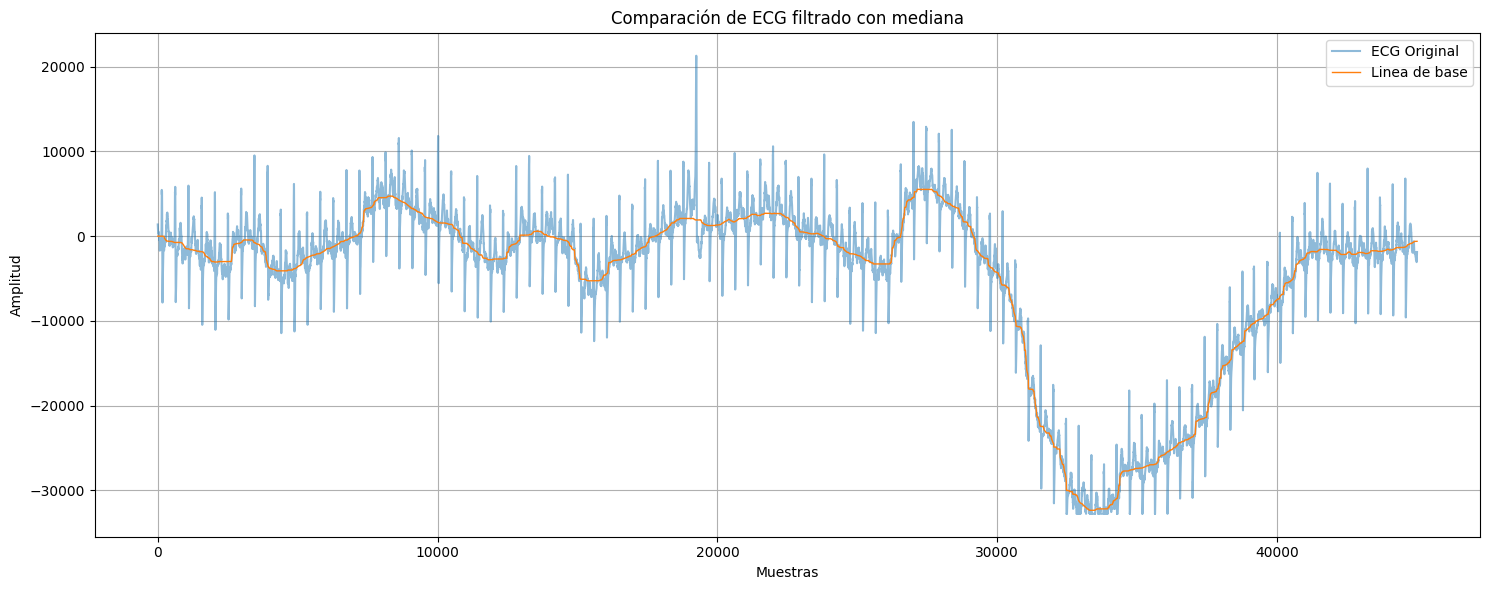

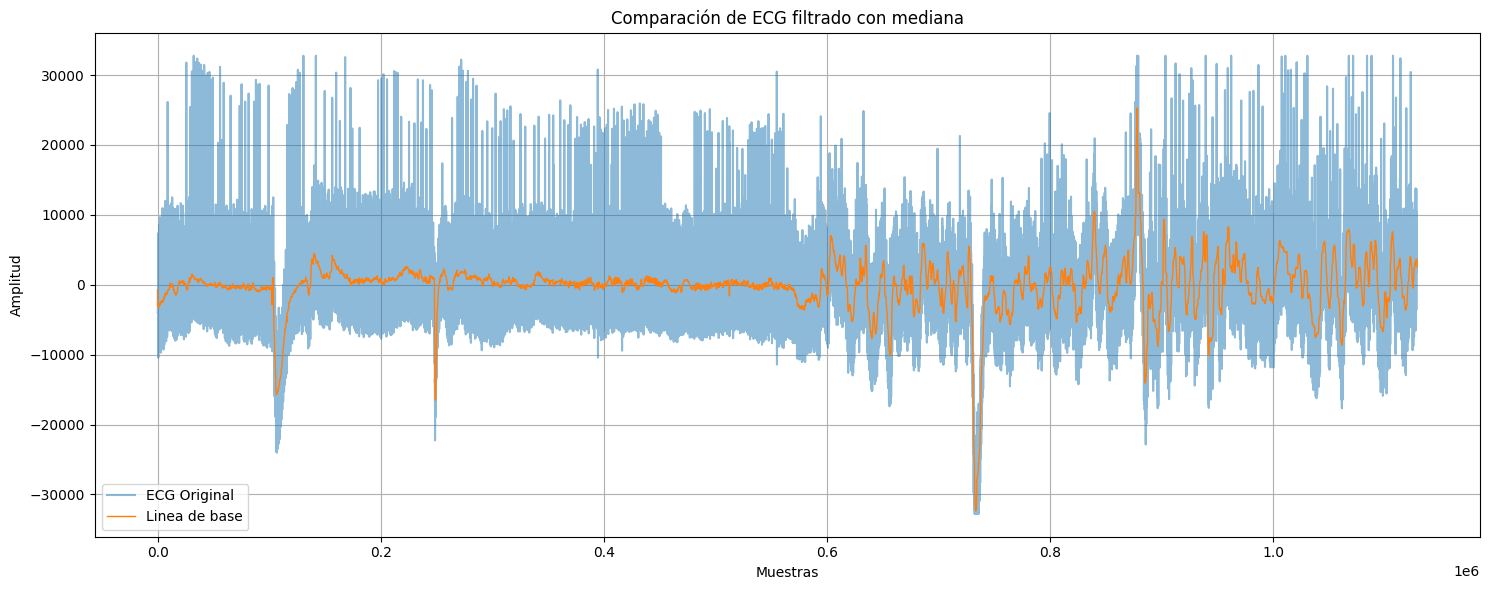

In [3]:
# Definir kernel_size 
kernel_size = 201
kernel_size_2 = 1201

# N = len(ecg_one_lead) 
ecg=ecg_one_lead[700000:745000]
medfilt(ecg, kernel_size=None)

# Aplicar filtro mediano ventana 200ms
ecg_filtradovgrande = medfilt(ecg, kernel_size=kernel_size)

# Aplicar filtro mediano ventana 600ms
ecg_filtradovchica=medfilt(ecg_filtradovgrande, kernel_size=kernel_size_2)

# Gráfica
plt.figure(figsize=(15, 6))
plt.plot(ecg, label='ECG Original', alpha=0.5)

plt.plot(ecg_filtradovchica, label='Linea de base', linewidth=1)
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.title('Comparación de ECG filtrado con mediana')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# %%
# Toda la senal 
# Aplicar filtro mediano ventana 200ms
ecg_filtradovgrande2 = medfilt(ecg_one_lead, kernel_size=kernel_size)

# Aplicar filtro mediano ventana 600ms
ecg_filtradovchica2=medfilt(ecg_filtradovgrande2, kernel_size=kernel_size_2)

# Gráfica
plt.figure(figsize=(15, 6))
plt.plot(ecg_one_lead, label='ECG Original', alpha=0.5)

plt.plot(ecg_filtradovchica2, label='Linea de base', linewidth=1)
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.title('Comparación de ECG filtrado con mediana')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# jugar con las ventanas, probar ppg q es un buen candidato

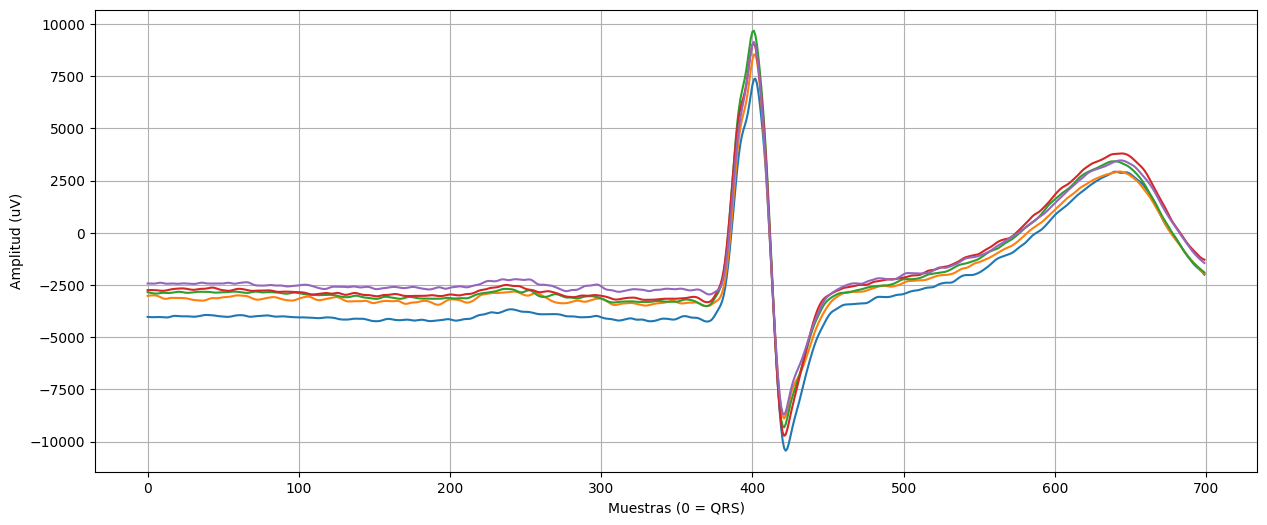

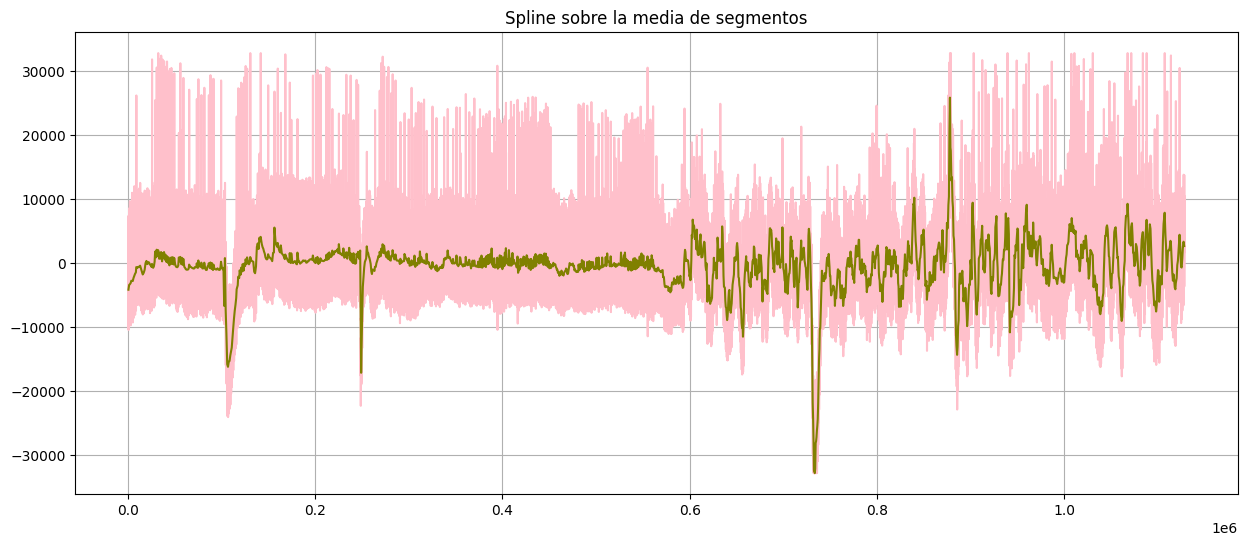

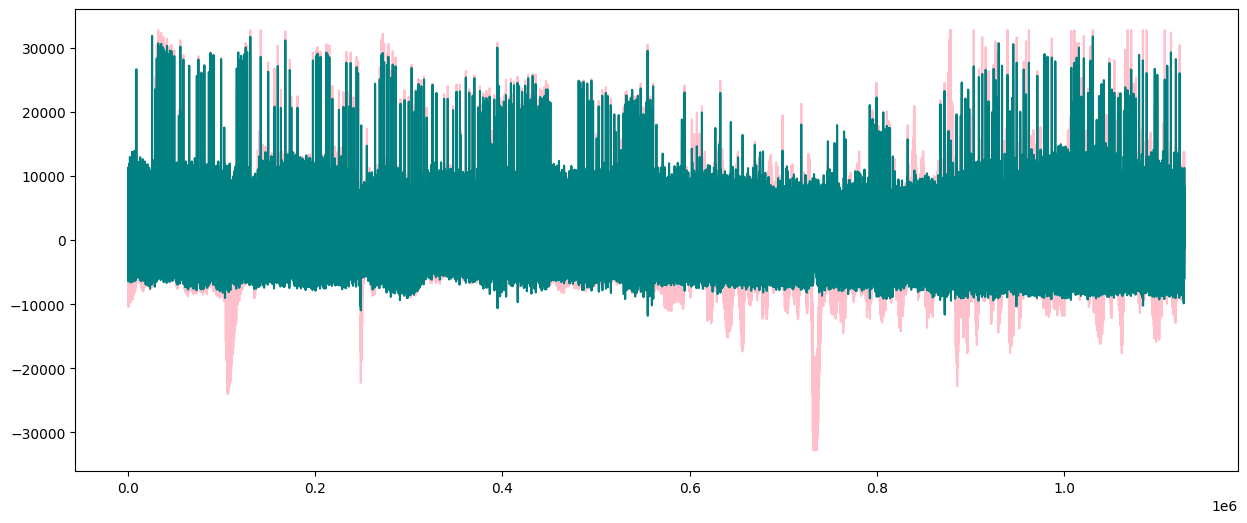

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.interpolate import CubicSpline
def vertical_flaten(a):
    return a.reshape(a.shape[0], 1)

# Lectura de ECG
fs_ecg = 1000  # Hz
mat_struct = sio.loadmat('./ECG_TP4.mat')
ecg_one_lead = vertical_flaten(mat_struct['ecg_lead']).flatten()
qrs_indices = mat_struct['qrs_detections'].flatten()
pre = 400  # muestras antes del QRS 
post = 300
segmentos = []
for idx in qrs_indices:
    if idx - pre >= 0 and idx + post< len(ecg_one_lead):
        segmento = ecg_one_lead[idx - pre :  idx+post]
        segmentos.append(segmento)

# Convertir a array 2D: cada fila es un segmento
segmentos_array = np.array(segmentos)

# Graficar los primeros 5 latidos superpuestos
plt.figure(figsize=(15, 6))
for i in range(5):
    plt.plot(segmentos_array[i], label=f'Segmento {i+1}')
plt.xlabel('Muestras (0 = QRS)')
plt.ylabel('Amplitud (uV)')
plt.grid(True)
plt.show()

#%%
# Parámetros de ventana alrededor del QRS
pre = 90  # muestras antes del QRS 
post = 20  # muestras 20ms despues de pre

# Extraer segmentos alrededor de los picos QRS
segmentos = []
for idx in qrs_indices:
    if idx - pre >= 0 and idx - pre + post < len(ecg_one_lead):
        segmento = ecg_one_lead[idx - pre :  idx - pre + post]
        segmentos.append(segmento)

# Convertir a array 2D: cada fila es un segmento
segmentos_array = np.array(segmentos)
# %% Estimacion de b en cada segmentos - grafico ECG ruidoso con linea de base 

# Calcular la media de cada segmento (fila)
medias_segmentos = np.mean(segmentos_array, axis=1)
x=qrs_indices - pre
cs = CubicSpline(x, medias_segmentos)
plt.figure(figsize=(15, 6))
plt.plot(ecg_one_lead, color='pink')
plt.plot(x, cs(x), color='olive')
plt.title("Spline sobre la media de segmentos")
plt.grid(True)
plt.show()

# %% Resto linea de base al ECG 

cs = CubicSpline(x, medias_segmentos, extrapolate=True)
spline_full = cs(np.arange(len(ecg_one_lead)))
ECG_sin_b = ecg_one_lead - spline_full
plt.figure(figsize=(15, 6))
plt.plot(ecg_one_lead, color='pink')
plt.plot(ECG_sin_b, color='teal')

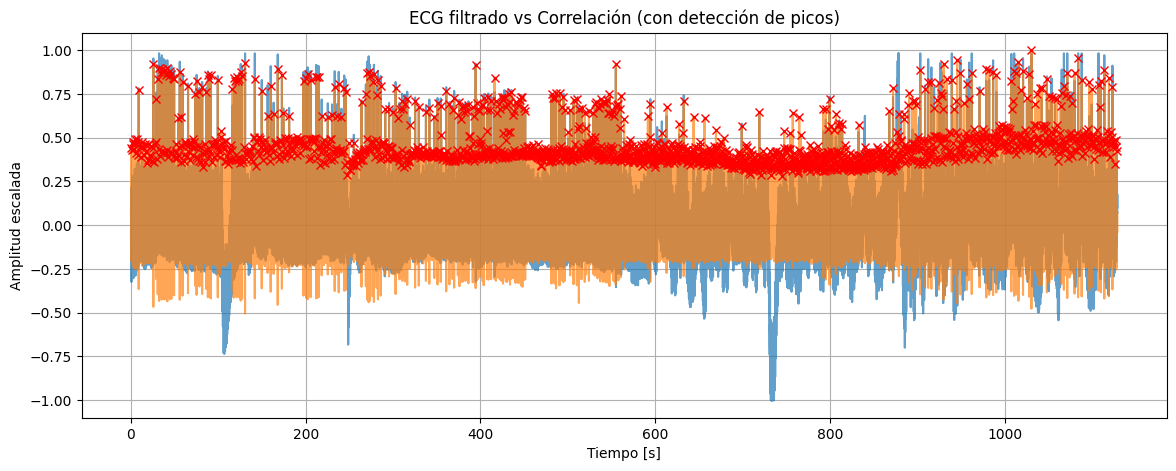

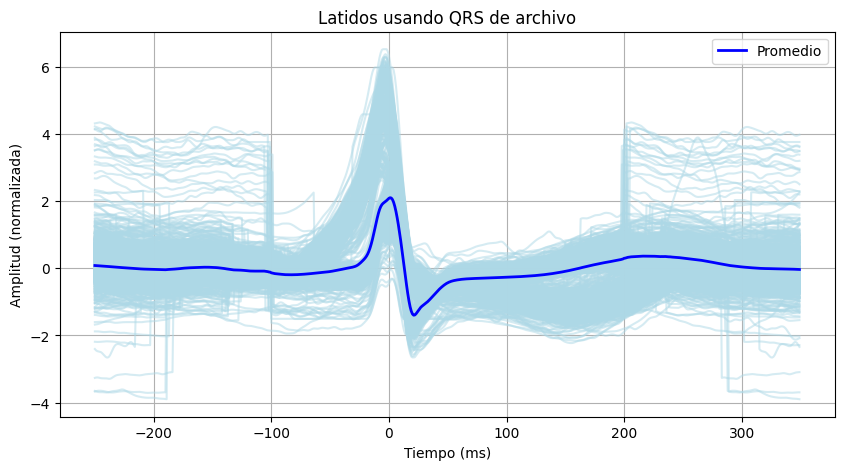

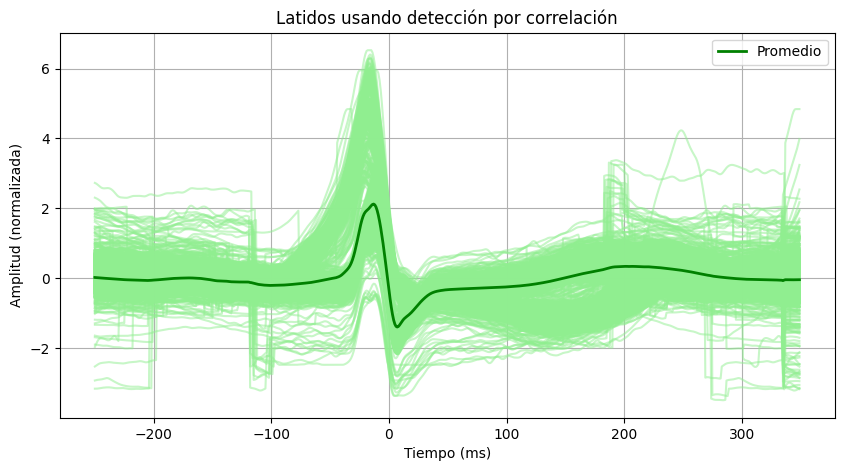

In [9]:
from scipy.signal import find_peaks, correlate
import scipy.signal as sig
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import scipy.io as sio
def vertical_flaten(a):
    return a.reshape(a.shape[0], 1)

# Cargar la señal ECG
fs= 1000  # Hz
mat_struct = sio.loadmat('./ECG_TP4.mat')

# Extraer las señales
ecg_one_lead = mat_struct['ecg_lead'].flatten()
hb1 = mat_struct['heartbeat_pattern1'].flatten()
hb2 = mat_struct['heartbeat_pattern2'].flatten()
qrs_pattern= mat_struct['qrs_pattern1'].flatten()
qrs_indices = mat_struct['qrs_detections'].flatten()

# Paso 1: Normalización
ecg_filtrada_norm = (ecg_one_lead - np.mean(ecg_one_lead)) / np.std(ecg_one_lead)
qrs_pattern_norm = (qrs_pattern - np.mean(qrs_pattern)) / np.std(qrs_pattern)

# Paso 2: Correlación normalizada
corr_norm = sig.correlate(ecg_filtrada_norm, qrs_pattern_norm, mode='same')

# Paso 3: Reescalado
ecg_rescaled = ecg_filtrada_norm / np.max(np.abs(ecg_filtrada_norm))
corr_rescaled = corr_norm / np.max(np.abs(corr_norm))

# Paso 4: Detección de picos en la correlación reescalada
threshold = 0.25  # Umbral relativo al máximo
peaks, properties = find_peaks(corr_rescaled, height=threshold, distance=200)
 
t_ecg=np.arange(len(corr_rescaled))/fs
# Paso 5: Gráfico conjunto
plt.figure(figsize=(14, 5))
plt.plot(t_ecg, ecg_rescaled, label='ECG filtrado (normalizado)', alpha=0.7)
plt.plot(t_ecg, corr_rescaled, label='Correlación normalizada (reescalada)', alpha=0.7)
plt.plot(t_ecg[peaks], corr_rescaled[peaks], 'rx', label='Picos de correlación')
plt.title('ECG filtrado vs Correlación (con detección de picos)')
plt.xlabel("Tiempo [s]")
plt.ylabel("Amplitud escalada")
plt.grid(True)
plt.show()
# %%

# VER LATIDOS SUPERPUESTOS CON QRS DETECTADO EN MAT STRUCT
# Paso 5: Comparación de latidos superpuestos

pre = 250  # muestras antes del QRS
post = 350  # muestras después
t = np.arange(-pre, post) * 1000 / fs  # eje en ms

def extraer_segmentos(indices, señal):
    segmentos = []
    for idx in indices:
        if idx - pre >= 0 and idx + post < len(señal):
            segmento = señal[idx - pre : idx + post]
            segmento -= np.mean(segmento)
            segmentos.append(segmento)
    return np.array(segmentos)

# 1. Latidos usando QRS del archivo
segmentos_mat = extraer_segmentos(qrs_indices, ecg_filtrada_norm)

plt.figure(figsize=(10,5))
for i in range(len(segmentos_mat)):
    plt.plot(t, segmentos_mat[i], color='lightblue', alpha=0.5)
plt.plot(t, np.mean(segmentos_mat, axis=0), color='blue', label='Promedio', linewidth=2)
plt.title('Latidos usando QRS de archivo')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Amplitud (normalizada)')
plt.grid(True)
plt.legend()
plt.show()

# 2. Latidos usando detección propia (correlación)
segmentos_detectados = extraer_segmentos(peaks, ecg_filtrada_norm)

plt.figure(figsize=(10,5))
for i in range(len(segmentos_detectados)):
    plt.plot(t, segmentos_detectados[i], color='lightgreen', alpha=0.5)
plt.plot(t, np.mean(segmentos_detectados, axis=0), color='green', label='Promedio', linewidth=2)
plt.title('Latidos usando detección por correlación')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Amplitud (normalizada)')
plt.grid(True)
plt.legend()
plt.show()
# %%
# VER LATIDOS SUPERPUESTOS CON QRS DETECTADO EN MAT STRUCT


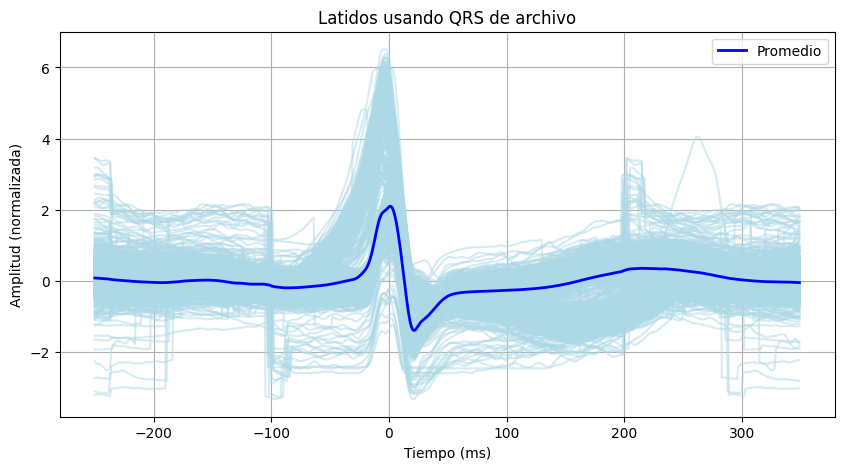

<Figure size 1000x500 with 0 Axes>

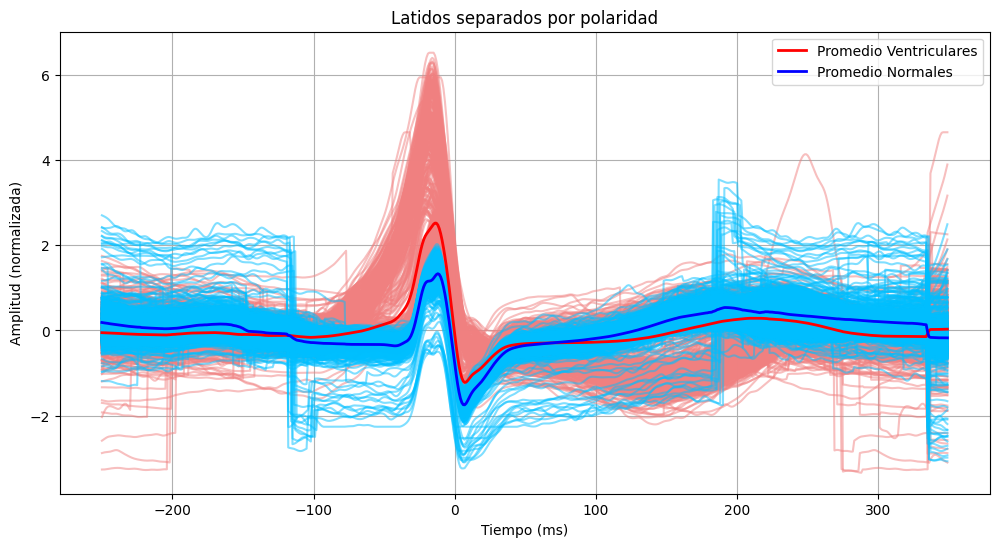

In [10]:
# %%

# VER LATIDOS SUPERPUESTOS CON QRS DETECTADO EN MAT STRUCT
# Paso 5: Comparación de latidos superpuestos

pre = 250  # muestras antes del QRS
post = 350  # muestras después
t = np.arange(-pre, post) * 1000 / fs  # eje en ms

def extraer_segmentos(indices, señal):
    segmentos = []
    for idx in indices:
        if idx - pre >= 0 and idx + post < len(señal):
            segmento = señal[idx - pre : idx + post]
            segmento -= np.mean(segmento)
            segmentos.append(segmento)
    return np.array(segmentos)

# 1. Latidos usando QRS del archivo
segmentos_mat = extraer_segmentos(qrs_indices, ecg_filtrada_norm)

plt.figure(figsize=(10,5))
for i in range(len(segmentos_mat)):
    plt.plot(t, segmentos_mat[i], color='lightblue', alpha=0.5)
plt.plot(t, np.mean(segmentos_mat, axis=0), color='blue', label='Promedio', linewidth=2)
plt.title('Latidos usando QRS de archivo')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Amplitud (normalizada)')
plt.grid(True)
plt.legend()
plt.show()

# 2. Latidos usando detección propia (correlación)
segmentos_detectados = extraer_segmentos(peaks, ecg_filtrada_norm)

plt.figure(figsize=(10,5))

# Supongamos que "segmentos_detectados" es tu array de latidos (cada fila es un latido)
ventana_central = slice(pre - 50, pre + 50)  # Por ejemplo, +/-50 muestras alrededor del centro

positivos = []
negativos = []

for latido in segmentos_detectados:
    centro = latido[ventana_central]
    max_abs = np.max(np.abs(centro))
    if np.max(centro) == max_abs:
        positivos.append(latido)
    else:
        negativos.append(latido)

positivos = np.array(positivos)
negativos = np.array(negativos)

# Ahora los grafico separados
plt.figure(figsize=(12, 6))
for s in positivos:
    plt.plot(t, s, color='lightcoral', alpha=0.5)
for s in negativos:
    plt.plot(t, s, color='deepskyblue', alpha=0.5)

# Promedio general
plt.plot(t, np.mean(positivos, axis=0), color='red', label='Promedio Ventriculares', linewidth=2)
plt.plot(t, np.mean(negativos, axis=0), color='blue', label='Promedio Normales', linewidth=2)

plt.title("Latidos separados por polaridad")
plt.xlabel("Tiempo (ms)")
plt.ylabel("Amplitud (normalizada)")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
Este grafico esta medio mal creo porque el promedio de los ventriculares tendria q ser mas alto